# RQ2: How have genre preferences changes over time across different regions?

## 1. Prepare the environment

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf



## 2. Prepare the data

In [284]:
df = pd.read_csv('final_dataset.csv', parse_dates=['released'], dayfirst=False)
df['Year'] = df['released'].dt.year
region_cols = ['NA_Sales(MM)', 'EU_Sales(MM)', 'JP_Sales(MM)', 'Other_Sales(MM)']
colors_dict = {
    'NA_Sales(MM)': '#ff7f0e',  # orange
    'EU_Sales(MM)': '#2ca02c',  # green
    'JP_Sales(MM)': '#1f77b4',  # blue
    'Other_Sales(MM)': '#9467bd'  # purple
}
df_melted = df.melt(id_vars=['Year', 'Genre'], value_vars=region_cols,
                    var_name='Region', value_name='Sales_MM')
df_melted['Region'] = df_melted['Region'].str.replace('_Sales\\(MM\\)', '')
df_melted = df_melted[df_melted['Sales_MM'] > 0]
genre_trends = df_melted.groupby(['Year', 'Genre', 'Region'])['Sales_MM'].sum().reset_index()


# 3. Analysis

### 3.1 Genre Trends by Region

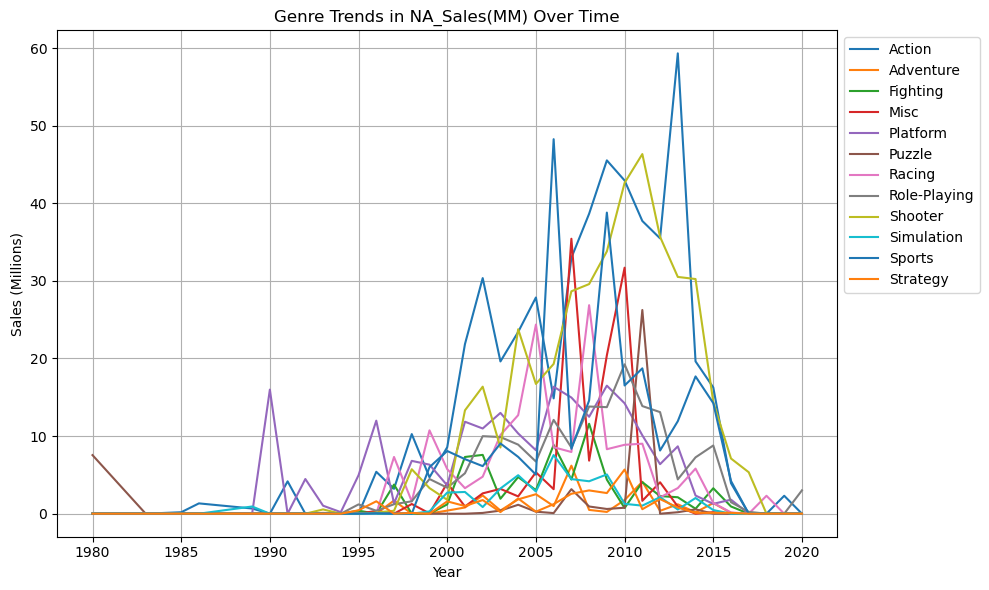

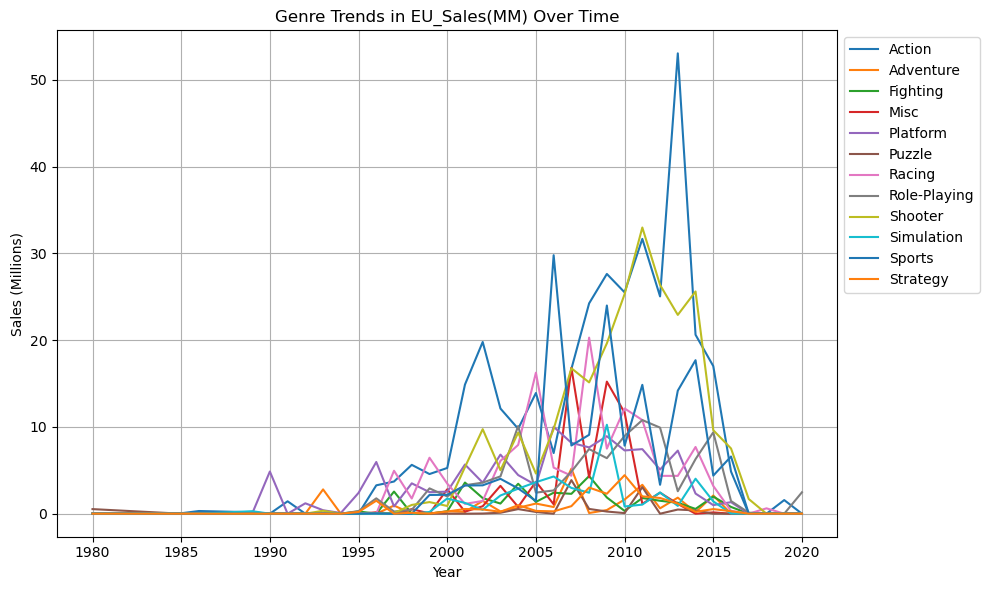

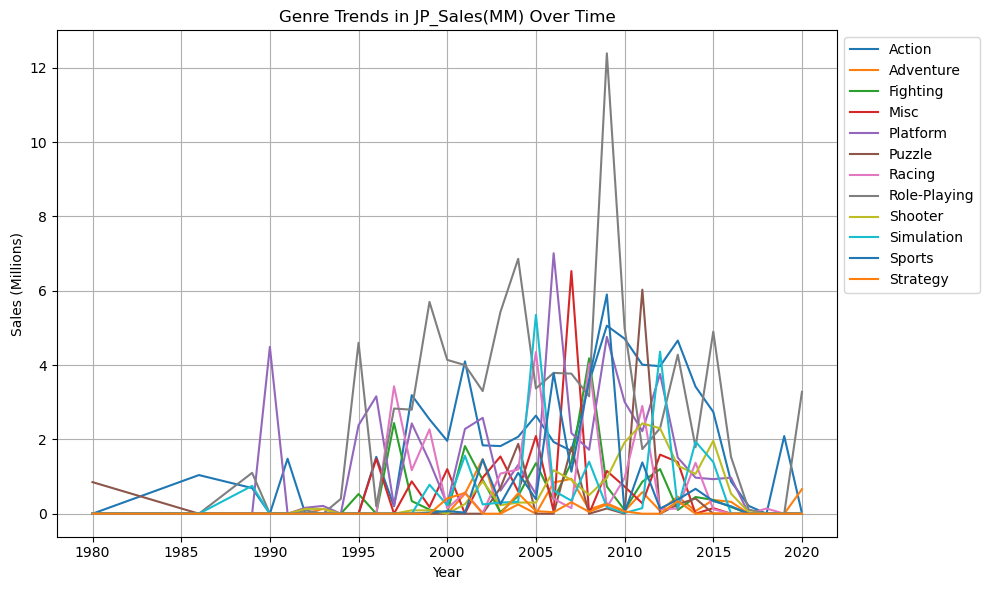

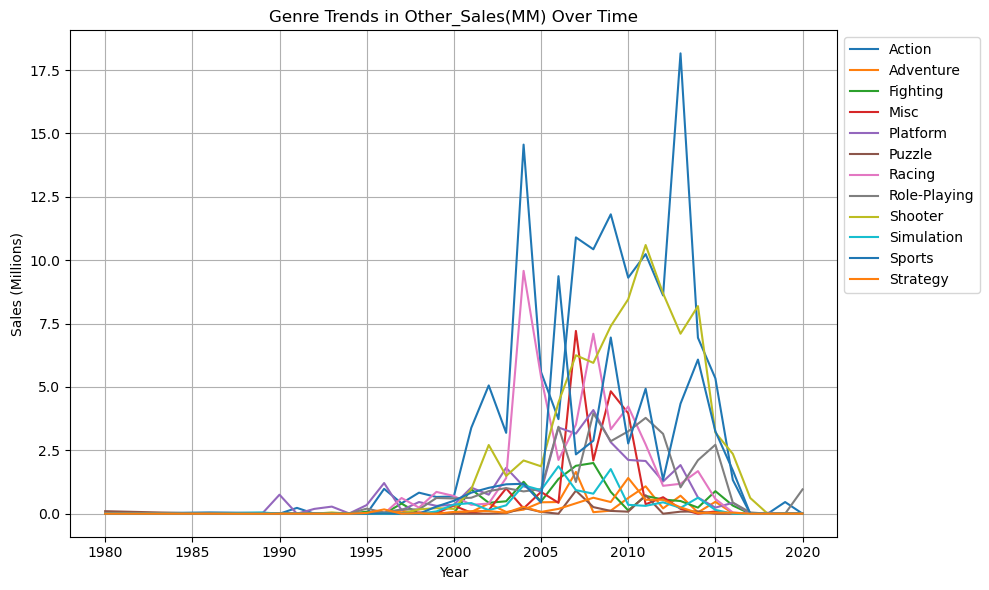

In [287]:
for region in df_melted['Region'].unique():
    temp = genre_trends[genre_trends['Region'] == region].pivot(index='Year', columns='Genre', values='Sales_MM').fillna(0)
    temp.plot(title=f"Genre Trends in {region} Over Time", figsize=(10, 6))
    plt.ylabel("Sales (Millions)")
    plt.xlabel("Year")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### 3.2 Distribution of Game's Genre by Region

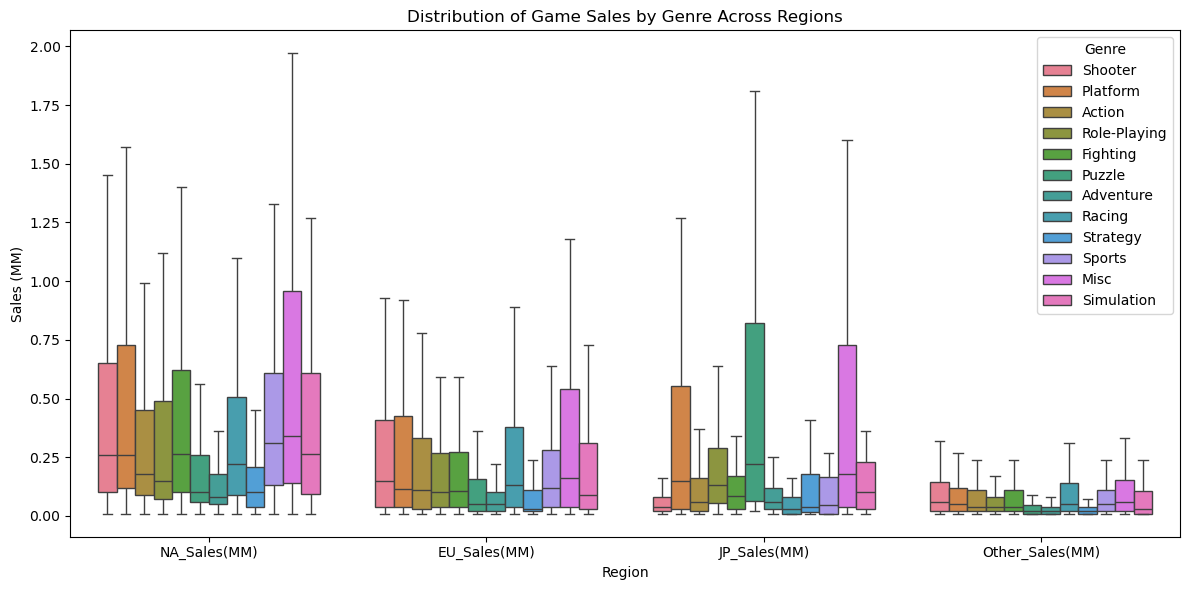

In [289]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Region', y='Sales_MM', hue='Genre', showfliers=False)
plt.title("Distribution of Game Sales by Genre Across Regions")
plt.ylabel("Sales (MM)")
plt.tight_layout()
plt.show()


### 3.3 Genre Sales by Decades

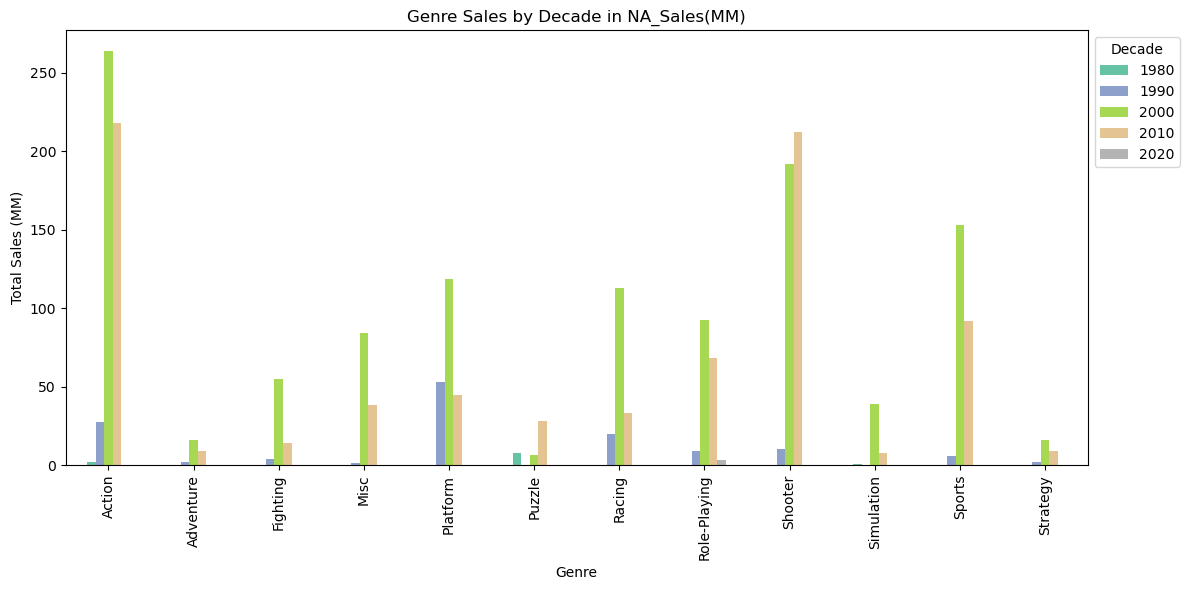

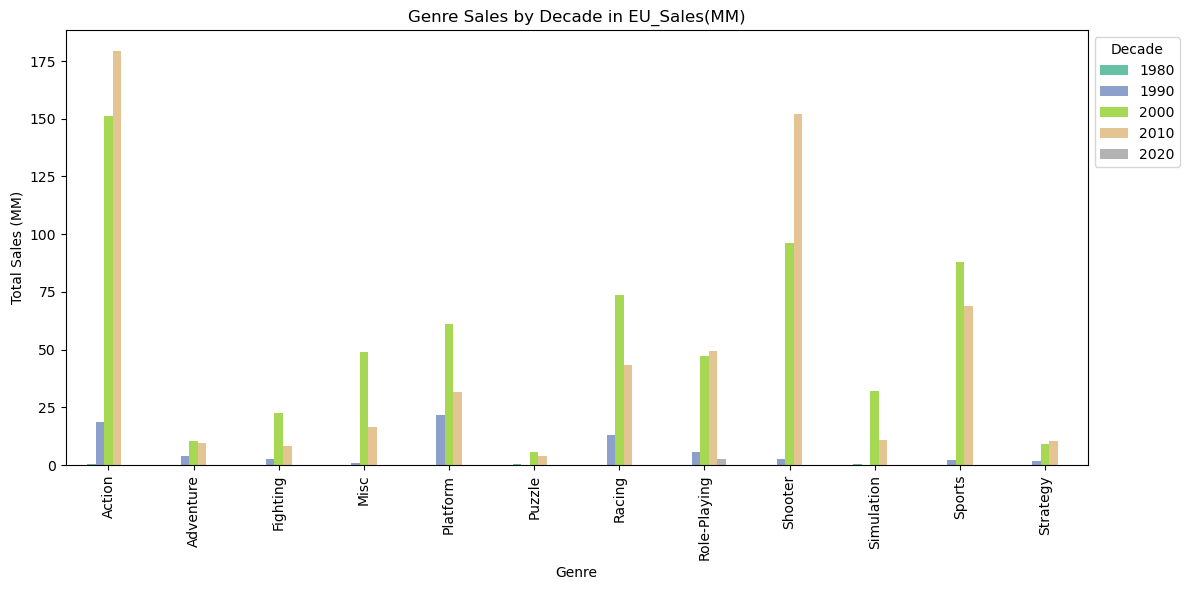

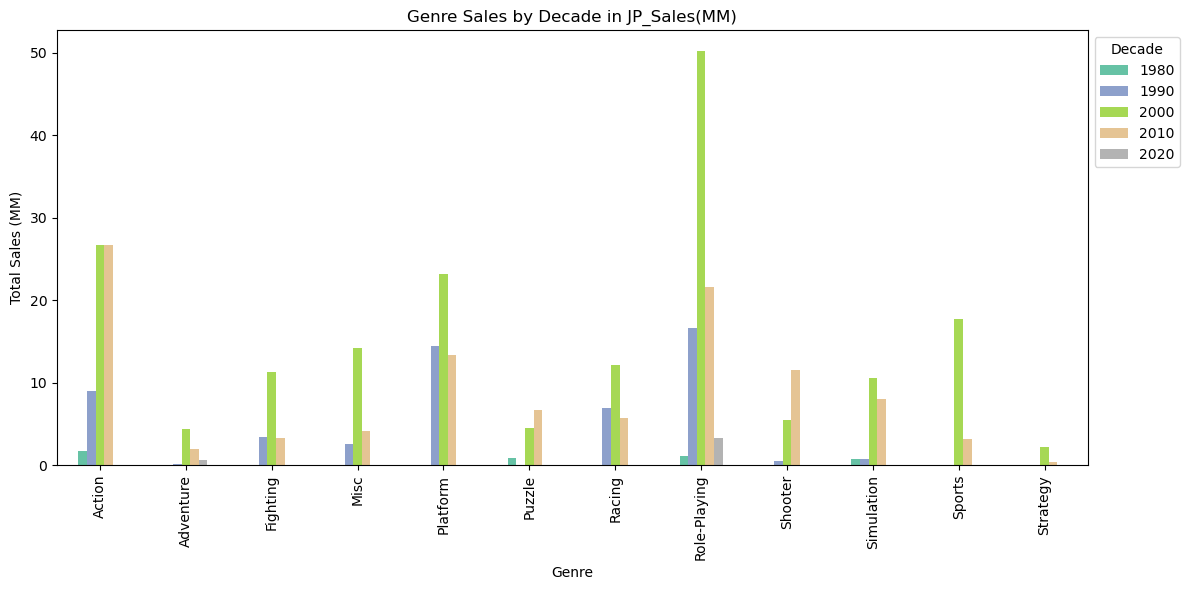

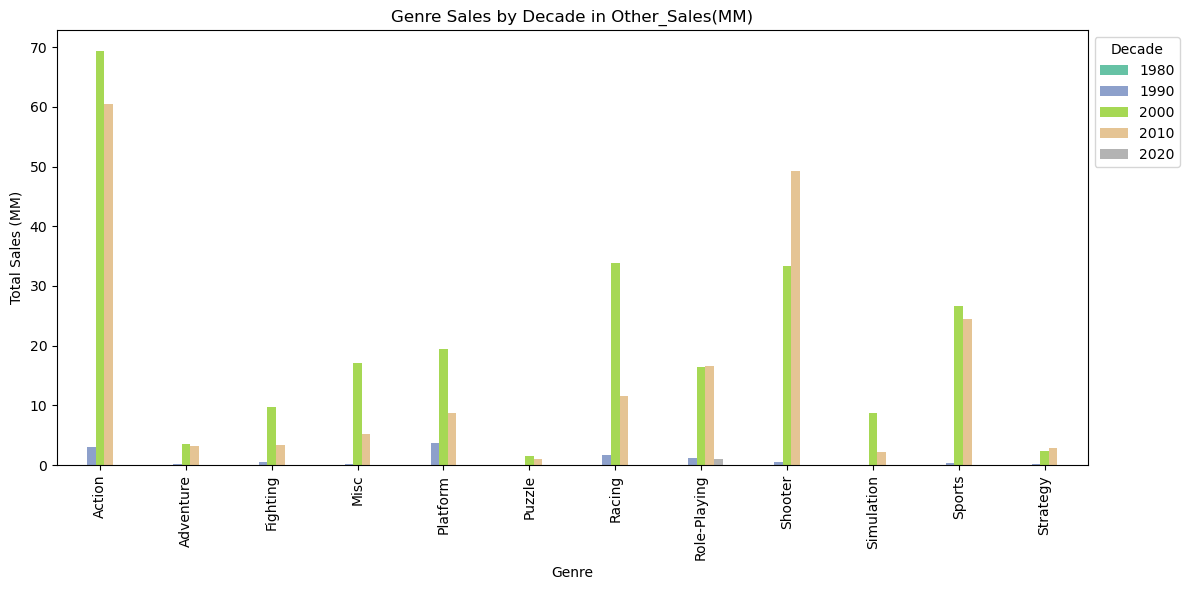

In [291]:
df['Decade'] = (df['Year'] // 10) * 10
decade_grouped = df_melted.copy()
decade_grouped['Decade'] = (decade_grouped['Year'] // 10) * 10

for region in decade_grouped['Region'].unique():
    temp = decade_grouped.groupby(['Decade', 'Genre', 'Region'])['Sales_MM'].sum().reset_index()
    temp = temp[temp['Region'] == region]
    pivot = temp.pivot(index='Genre', columns='Decade', values='Sales_MM').fillna(0)

    pivot.plot(kind='bar', figsize=(12, 6), colormap='Set2')
    plt.title(f"Genre Sales by Decade in {region}")
    plt.ylabel("Total Sales (MM)")
    plt.xlabel("Genre")
    plt.legend(title="Decade", bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### 3.4 Genre Diversity

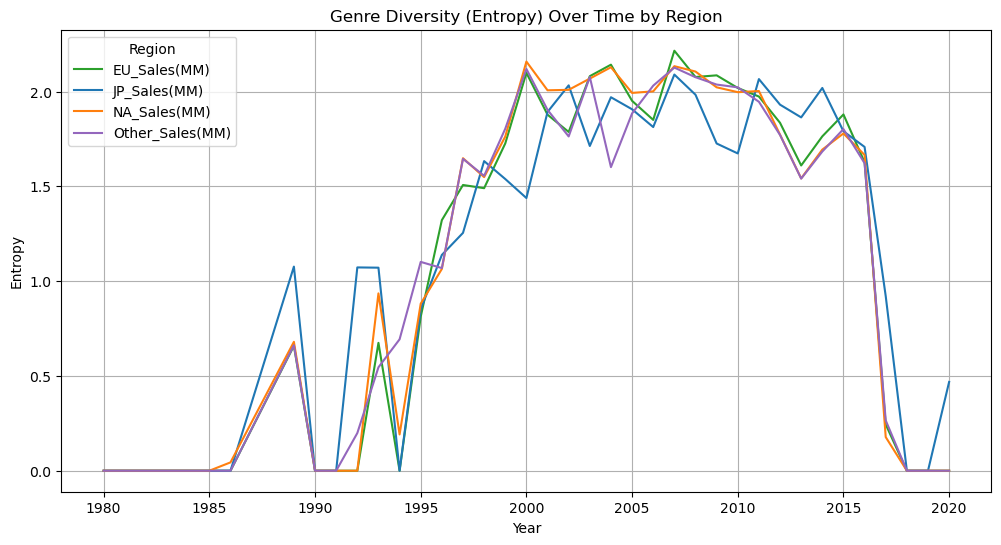

In [308]:
from scipy.stats import entropy

def compute_entropy(group):
    p = group['Sales_MM'].values
    return entropy(p / p.sum())

entropies = df_melted.groupby(['Year', 'Region', 'Genre'])['Sales_MM'].sum().reset_index()
entropies = entropies.groupby(['Year', 'Region']).apply(compute_entropy, include_groups=False).reset_index()
entropies.columns = ['Year', 'Region', 'Entropy']

plt.figure(figsize=(12, 6))
sns.lineplot(data=entropies, x='Year', y='Entropy', hue='Region', palette=colors_dict)
plt.title('Genre Diversity (Entropy) Over Time by Region')
plt.grid(True)
plt.show()



### 3.5 Percentage share (Genre)

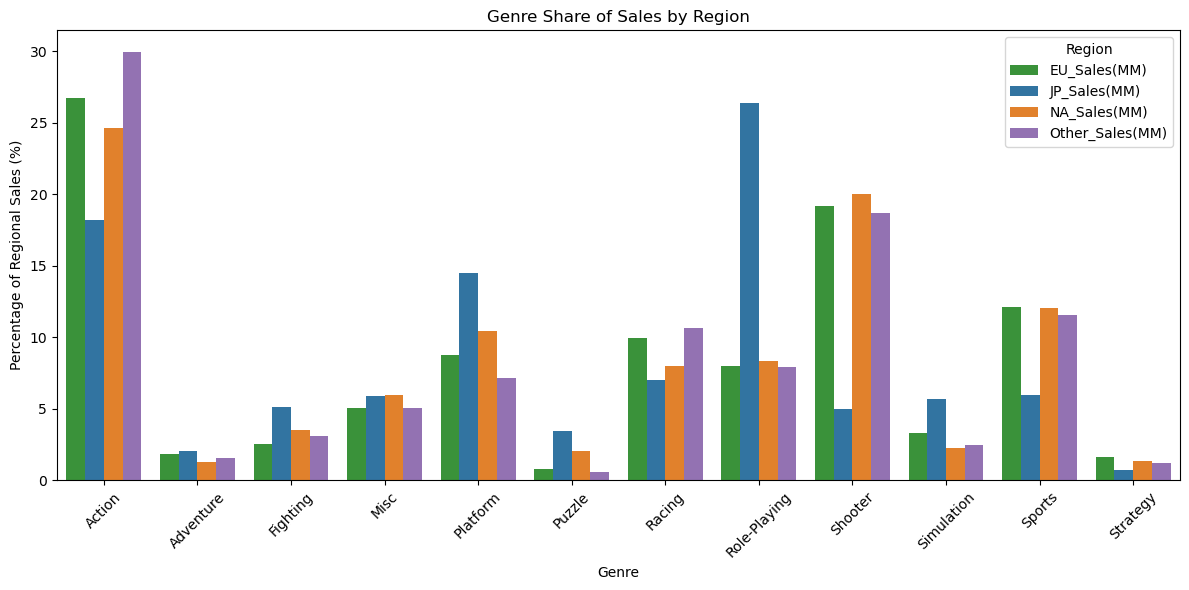

In [295]:
# Normalize by total regional sales per region
genre_region_total = genre_trends.groupby(['Region', 'Genre'])['Sales_MM'].sum().reset_index()
total_sales = genre_region_total.groupby('Region')['Sales_MM'].transform('sum')
genre_region_total['Sales_Pct'] = (genre_region_total['Sales_MM'] / total_sales) * 100

plt.figure(figsize=(12, 6))
sns.barplot(data=genre_region_total, x='Genre', y='Sales_Pct', hue='Region', palette=colors_dict)
plt.xticks(rotation=45)
plt.title('Genre Share of Sales by Region')
plt.ylabel('Percentage of Regional Sales (%)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()